# 03. Model Interpretability with SHAP
In this notebook, we use SHAP (SHapley Additive exPlanations) to explain the XGBoost model's predictions. This provides transparency into why certain loans are flagged as high risk.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

C:\Users\Manu Kumar\.conda\envs\risk_modelling\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data and prepare as in previous step
df = pd.read_csv('../data/final_modeling_data.csv')
categorical_cols = ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]
target = 'loan_default'

df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Best params from 02_advanced_modeling
best_params = {'subsample': 0.7, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
scale_weight = float(np.sum(y_train == 0) / np.sum(y_train == 1))

model = XGBClassifier(**best_params, scale_pos_weight=scale_weight, random_state=42)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

## 1. Global Interpretability
Summary plot shows the impact of each feature across the entire dataset.

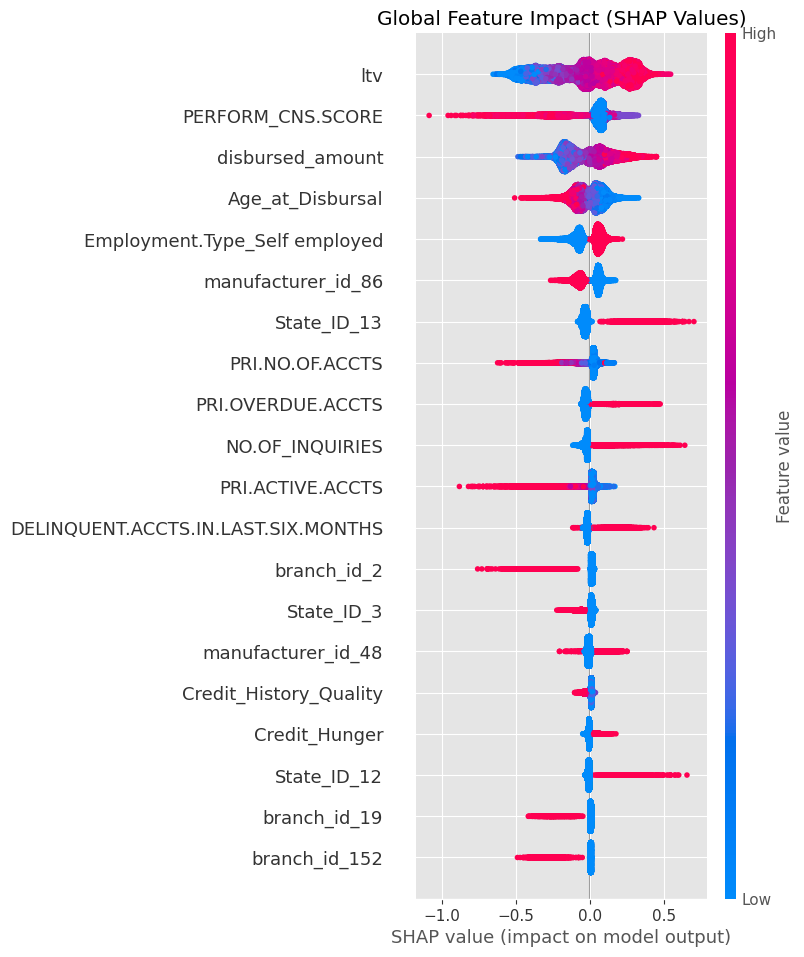

In [3]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('Global Feature Impact (SHAP Values)')
plt.show()

## Global Feature Impact – SHAP Analysis

This SHAP summary plot explains **how each feature globally influences the XGBoost model’s predictions**, showing both **importance** and **direction of impact**.

---

### Key Drivers of Default Risk

- **LTV** is the strongest risk driver  
  Higher LTV values (red) push predictions strongly toward **default**, while lower LTV reduces risk.

- **Credit Bureau Score (PERFORM_CNS.SCORE)** is the strongest protective factor  
  Low scores increase default risk; high scores consistently reduce it.

- **Disbursed Amount**  
  Larger loan amounts increase default probability, confirming repayment burden effects.

- **Age at Disbursal**  
  Younger borrowers push predictions toward higher risk; older age mitigates default likelihood.

- **Self-Employment**  
  Self-employed status increases default risk due to income volatility.

---

### Credit Behavior Signals

- **Number of Accounts, Overdues, Inquiries, Delinquencies**  
  Higher values consistently push predictions toward default, validating credit behavior as a key risk pillar.

- **Credit Hunger & Credit History Quality**  
  Engineered features show clear directional impact, confirming value of feature engineering.

---

### Operational & Geographic Effects

- **Branch and State IDs**  
  Certain branches and states systematically shift risk, capturing operational and regional patterns.

- **Manufacturer IDs**  
  Reflect asset-level and customer-segment risk differences.

---

### Key Takeaways

- Model decisions are **business-aligned and intuitive**
- Risk is driven by a **combination of leverage, credit history, borrower stability, and behavior**
- SHAP confirms that **engineered interaction features add real explanatory value**

**Conclusion:**  
The SHAP analysis validates that the XGBoost model learns **meaningful, explainable risk patterns**, making it suitable for both **production deployment and stakeholder communication**.


## 2. Local Interpretability & Segment Analysis
Explaining specific segments like the 'Triple Threat'.

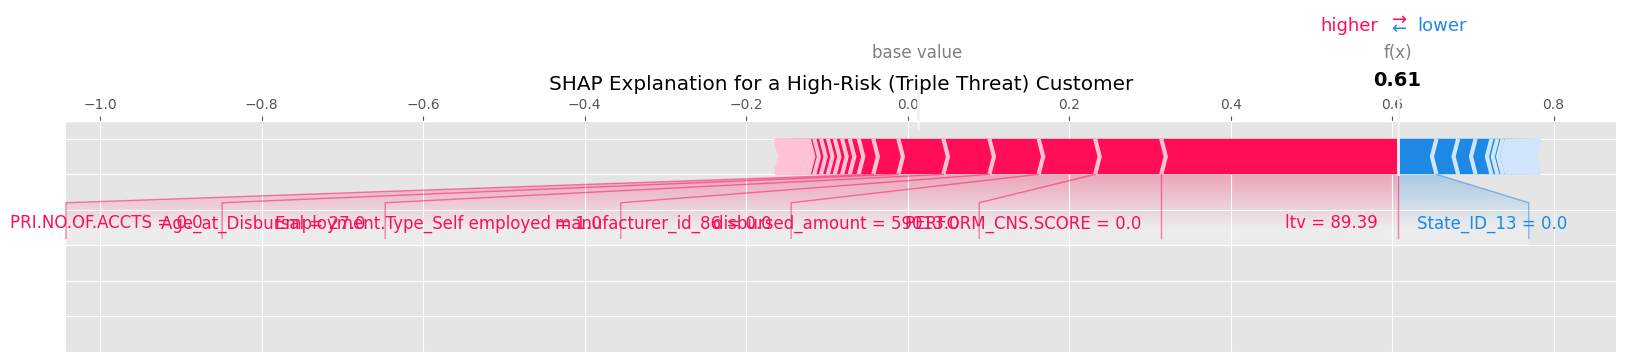

In [4]:
# Explain a high-risk instance (Triple Threat)
high_risk = X_test[X_test['Triple_Threat'] == 1].iloc[0]
shap_val_single = explainer.shap_values(high_risk.values.reshape(1, -1))

shap.force_plot(explainer.expected_value, shap_val_single[0], high_risk, matplotlib=True, show=False)
plt.title('SHAP Explanation for a High-Risk (Triple Threat) Customer')
plt.show()

## Local SHAP Explanation – High-Risk (Triple Threat) Customer

This SHAP force plot explains **why the model classified this borrower as high risk**, breaking down feature-level contributions.

### Key Risk Drivers (pushing toward Default)
- **High LTV (~89%)** → strongest contributor to increased risk
- **Self-employed status** → income volatility raises default probability
- **Young age at disbursal** → amplifies leverage-related risk
- **High number of active accounts** → elevated credit exposure
- **Manufacturer-specific effect** → asset/customer segment risk

### Risk Mitigators (pulling away from Default)
- **State_ID_13** → slightly lower regional risk
- Limited mitigating impact compared to strong risk drivers

### Overall Interpretation
- Multiple high-risk signals **compound**, pushing the prediction far above the base risk
- This is a textbook **“Triple Threat” case**, where leverage, employment volatility, and borrower profile align

**Conclusion:**  
The model’s decision is **transparent, intuitive, and policy-aligned**, clearly showing why this borrower warrants **manual review or rejection under stricter underwriting rules**.


## 3. Interaction Plot
Visualizing the interaction between LTV and Age, which we flagged in EDA.

## Confusion Matrix Analysis
Displaying TN, FP, FN, TP for a clearer view of classification errors.

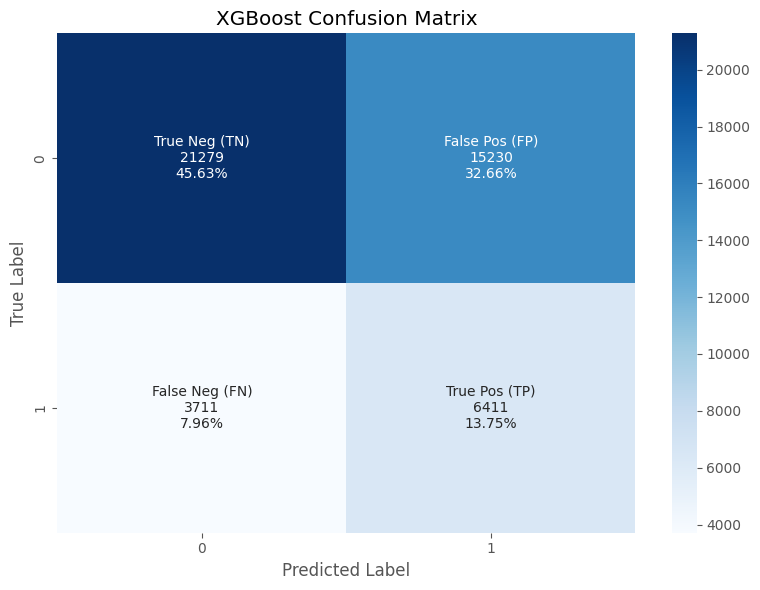

In [5]:
def plot_labeled_confusion_matrix(y_true, y_pred, title, ax):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg (TN)','False Pos (FP)','False Neg (FN)','True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, ax = plt.subplots(figsize=(8, 6))
plot_labeled_confusion_matrix(y_test, model.predict(X_test), 'XGBoost Confusion Matrix', ax)
plt.tight_layout()
plt.show()

## XGBoost Confusion Matrix – Interpretation

This confusion matrix shows the classification behavior of the **XGBoost model** at the selected decision threshold.

---

### Classification Breakdown

- **True Negatives (45.6%)**  
  Correctly identified non-defaulters

- **False Positives (32.7%)**  
  Safe borrowers incorrectly flagged as risky

- **False Negatives (8.0%)**  
  Defaulters missed by the model

- **True Positives (13.8%)**  
  Correctly identified defaulters

---

### Business Interpretation

- Model maintains a **strong balance between risk capture and approvals**
- Lower false positives compared to more aggressive thresholds
- Slightly higher false negatives indicate a **more conservative screening strategy**

---

### Trade-off Assessment

- **Reduced operational burden** vs aggressive models
- Acceptable risk leakage depending on business loss tolerance
- Suitable for **production deployment with monitoring**

---

### Conclusion

This XGBoost configuration offers a **balanced risk–reward trade-off**, making it appropriate for real-world decisioning when paired with **policy rules or segment-specific thresholds**.


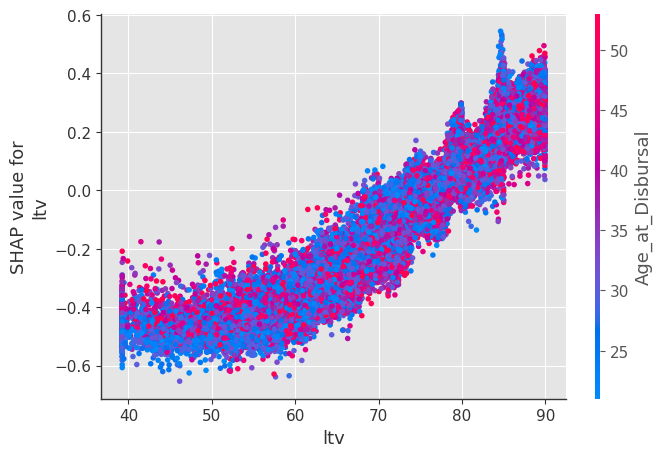

In [6]:
shap.dependence_plot('ltv', shap_values, X_test, interaction_index='Age_at_Disbursal')

## SHAP Dependence Plot – LTV vs Default Risk (Age Interaction)

This SHAP dependence plot illustrates how **Loan-to-Value (LTV)** influences default risk, while highlighting its **interaction with borrower age**.

---

### Key Observations

- **Clear monotonic relationship:**  
  As **LTV increases**, SHAP values rise sharply, pushing predictions toward **default**.

- **Low LTV (<60%)**  
  SHAP values are strongly negative → **low default risk**.

- **High LTV (>75%)**  
  SHAP values turn positive and increase rapidly → **high default risk**.

- **Age interaction effect:**  
  Younger borrowers (blue points) show **higher risk at the same LTV** compared to older borrowers (pink/red points).

---

### Business Interpretation

- **LTV is the dominant structural risk driver**
- Age acts as a **risk amplifier** rather than an independent factor
- High leverage is particularly dangerous for younger borrowers

---

### Modeling & Policy Implications

- Supports **non-linear modeling** of LTV
- Justifies:
  - Age × LTV interaction features
  - Stricter LTV caps for younger customers
- Enables explainable, rule-aligned credit decisions

---

### Conclusion

The SHAP dependence plot confirms that **default risk rises non-linearly with LTV**, and this effect is **amplified for younger borrowers**, reinforcing the need for interaction-aware modeling and policy controls.
